# Coryat Scores

The Coryat score is a metric to evaluate how well a contestant is playing. From the J! Archive Glossary:

    Coryat Score: a player's score if all wagering is disregarded. In the Coryat score, there is no penalty for forced incorrect responses on Daily Doubles, but correct responses on Daily Doubles earn only the natural values of the clues, and any gain or loss from the Final Jeopardy! Round is ignored.

    Named for Season 12 2-game champion Karl Coryat, who conceived of a scorekeeping method that would allow Jeopardy! hopefuls playing along at home to gauge their scores against the contestants playing on the show.
    

We begin this notebook by writing a function that return's a player's Coryat score, and their number of correct/incorrect answers. We use this function to find the Coryat score for every regular season game and concatenate them into a pandas dataframe. We only use regular season games because in every game the third contestant is always titled 'Returning Champion', however for tournaments there are no returning champions in the traditional sense. 

We then use the summed Coryat scores of all contestants and the standard deviation in Coryat score between contestants to create a rudimentary episode rating. Higher ratings correspond to higher combined Coryat scores and lower standard deviations. 

In [1]:
#Import packages and read datasets
#We filter warnings because the function returns the warning:
# SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
# Since this didn't affect the end results, I opted to ignore the warning
import warnings
warnings.simplefilter(action='ignore')

import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

os.chdir('C:\\Users\\mhous\\scrap\\JeopardyProject')
clues = pd.read_csv('clues.csv')
games = pd.read_csv('games_clean.csv')
regular_season = games[games['game_comments'].str.contains(r'^((?![Tt]ournament |Battle |[Cc]hampionship |Back |Kids |Million).)*$').fillna(True)]
reg_clues = clues[clues['show_number'].isin(regular_season['show_number'].tolist())]

In [2]:
ties = [301, 402, 483, 1153, 2243, 2735, 3868]
ties_show_number = []
for i in ties:
    ties_show_number.append(clues['show_number'].unique()[i])

In [3]:
def coryat(show_number):
    ties = [4150, 8023, 8039, 6370, 6895, 5332, 7709]
    
    FJ_data = games[['show_number', 'contestant_1', 'contestant_2', 'returning_champion']]
    FJ_game = FJ_data[FJ_data['show_number'] == show_number]

    df = reg_clues[['show_number','value','order_number', 'round', 'row', 'correct', 'incorrect']]
    df = df[df['show_number'] == show_number]

    conditions = [
        (df['round'] == 'J') & (df['row'] == 1.0),
        (df['round'] == 'J') & (df['row'] == 2.0),
        (df['round'] == 'J') & (df['row'] == 3.0),
        (df['round'] == 'J') & (df['row'] == 4.0),
        (df['round'] == 'J') & (df['row'] == 5.0),
        (df['round'] == 'DJ') & (df['row'] == 1.0),
        (df['round'] == 'DJ') & (df['row'] == 2.0),
        (df['round'] == 'DJ') & (df['row'] == 3.0),
        (df['round'] == 'DJ') & (df['row'] == 4.0),
        (df['round'] == 'DJ') & (df['row'] == 5.0),
        (df['round'] == 'FJ')
        ]

    values = [200, 400, 600, 800, 1000, 400, 800, 1200, 1600, 2000, np.NaN]

    df['base_value'] = np.select(conditions, values)
    df = df.drop([df.index.max()], axis=0)
    if show_number in ties:
        df = df.drop([df.index.max()], axis=0)
    
    df = df.fillna('')
    df = df.dropna()
    df['order_number'] = df['order_number'].astype(int)
    #list of all 3 contestants
    contestants = [FJ_game['contestant_1'].iloc[0].split(' ')[0], FJ_game['contestant_2'].iloc[0].split(' ')[0], FJ_game['returning_champion'].iloc[0].split(' ')[0]]
    #Initialize empty array of coryat scores
    coryats = np.zeros((3, 3))

    #subset for just the Jeopardy Round
    J_round = df[df['round'] == 'J']
    #for loop iterates over each player
    for contestant in range(3):
        #for each clue in jeopardy round
        for i in J_round['order_number']:
            #if contestant is in the 'correct' column of J_round for a clue, add that clue's base value to the contestant's coryat score
            if contestants[contestant] in J_round[J_round['order_number'] == i]['correct'].iloc[0]:
                coryats[0][contestant] += J_round[J_round['order_number'] == i]['base_value'].iloc[0]
                coryats[1][contestant] += 1
            #if contestant is in the 'incorrect' column of J_round for a clue, subtract that clue's base value to the contestant's coryat, unless it is a daily double
            elif contestants[contestant] in J_round[J_round['order_number'] == i]['incorrect'].iloc[0]:
                coryats[2][contestant] += 1
                if J_round[J_round['order_number'] == i]['value'].iloc[0][0] != 'D':
                    coryats[0][contestant] -= J_round[J_round['order_number'] == i]['base_value'].iloc[0]

    DJ_round = df[df['round'] == 'DJ']
    for contestant in range(3):
        for i in DJ_round['order_number']:
            if contestants[contestant] in DJ_round[DJ_round['order_number'] == i]['correct'].iloc[0]:
                coryats[0][contestant] += DJ_round[DJ_round['order_number'] == i]['base_value'].iloc[0]
                coryats[1][contestant] +=1
            elif contestants[contestant] in DJ_round[DJ_round['order_number'] == i]['incorrect'].iloc[0]:
                coryats[2][contestant] += 1
                if DJ_round[DJ_round['order_number'] == i]['value'].iloc[0][0] != 'D':
                    coryats[0][contestant] -= DJ_round[DJ_round['order_number'] == i]['base_value'].iloc[0]
    return coryats

In [4]:
base_game = pd.DataFrame()
games_show_numbers = reg_clues['show_number'].sort_values().unique()
for i in games_show_numbers:
    if i == 3966:
        data = coryat(i)
        arrays = [np.array([i, i, i]), np.array(['contestant_1', 'contestant_2', 'returning_champion'])]
        base_game = pd.DataFrame(data).transpose()
        base_game.index = arrays 
    else:
        data = coryat(i)
        arrays = [np.array([i, i, i]), np.array(['contestant_1', 'contestant_2', 'returning_champion'])]
        next_game = pd.DataFrame(data).transpose() 
        next_game.index = arrays
        base_game = pd.concat([base_game, next_game])
        
base_game.columns = ['coryat_score', 'n_correct', 'n_incorrect']
base_game

coryat_score  n_correct  n_incorrect
3966 contestant_1              8400.0       17.0          4.0
     contestant_2              3400.0       12.0          3.0
     returning_champion        5400.0       15.0          5.0
3967 contestant_1              7800.0        9.0          0.0
     contestant_2             18800.0       21.0          2.0
...                               ...        ...          ...
8260 contestant_2              4400.0       14.0          5.0
     returning_champion        8000.0       16.0          4.0
8261 contestant_1              6400.0       12.0          3.0
     contestant_2              8000.0       14.0          3.0
     returning_champion        8800.0       15.0          2.0

[10569 rows x 3 columns]

Unfortunately the coryat function is not perfect. In some games, if one contestant's name is a subset of another's (Dan and Dana, J and Jennifer) since 'Dan' is in 'Dana', then the shorter name will have its data plus the longer name's data. We see this happening when there are more than the 60 correct answers, which is normally the supremum. Technically an answer can be initially deemed incorrect then deemed correct after a commercial break, resulting in one question having 2 people correctly answer it, though that is not the case in the few games actually being dropped.

In [5]:
mask = base_game.groupby(level=0).sum()['n_correct'] >60 
to_drop = base_game.groupby(level=0).sum().index[mask].tolist()
coryat_df = base_game.drop(to_drop)
coryat_df.groupby(level=0).sum()

,coryat_score,n_correct,n_incorrect
3966,17200.0,44.0,12.0
3967,40000.0,50.0,5.0
3968,35200.0,52.0,8.0
3969,31200.0,49.0,10.0
3970,30400.0,45.0,9.0
...,...,...,...
8257,19200.0,40.0,15.0
8258,39800.0,48.0,4.0
8259,25200.0,45.0,11.0
8260,14600.0,38.0,14.0


In [6]:
coryat_df.groupby(level=1).mean()

,coryat_score,n_correct,n_incorrect
contestant_1,10109.772727,14.840909,2.734659
contestant_2,10041.022727,14.867330,2.747727
returning_champion,13661.420455,19.149148,2.782955


In [7]:
grouped_sum_coryat = coryat_df.groupby(level=0).sum()
grouped_sum_coryat['contestant_std'] = coryat_df.groupby(level=0)['coryat_score'].std(ddof=0).round()
grouped_sum_coryat['rating'] =  grouped_sum_coryat['coryat_score'] -  grouped_sum_coryat['contestant_std']
grouped_sum_coryat['rating_index'] = 100 * grouped_sum_coryat['rating']/grouped_sum_coryat['rating'].mean()

In [8]:
grouped_sum_coryat.sort_values(by = ['rating_index'], ascending=False).head(10)

,coryat_score,n_correct,n_incorrect,contestant_std,rating,rating_index
6517,51000.0,58.0,1.0,1424.0,49576.0,170.028245
7286,51400.0,58.0,1.0,2705.0,48695.0,167.006725
7280,48800.0,57.0,4.0,573.0,48227.0,165.401649
8006,53200.0,59.0,1.0,5118.0,48082.0,164.904350
8027,46800.0,57.0,4.0,163.0,46637.0,159.948509
4167,46800.0,57.0,4.0,432.0,46368.0,159.025933
5818,51600.0,58.0,2.0,5233.0,46367.0,159.022503
8116,47400.0,55.0,4.0,1071.0,46329.0,158.892177
8029,52000.0,58.0,0.0,5679.0,46321.0,158.864740
5635,47600.0,57.0,5.0,1907.0,45693.0,156.710920


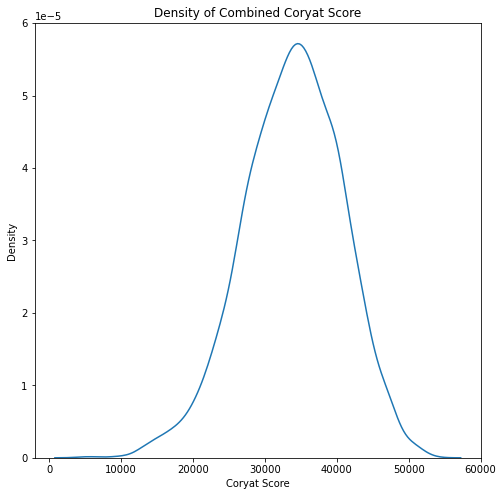

In [9]:
fig, ax = plt.subplots(figsize = (8,8))
sns.kdeplot(data=grouped_sum_coryat, x="coryat_score")
plt.title('Density of Combined Coryat Score')
plt.xlabel('Coryat Score')
plt.show()

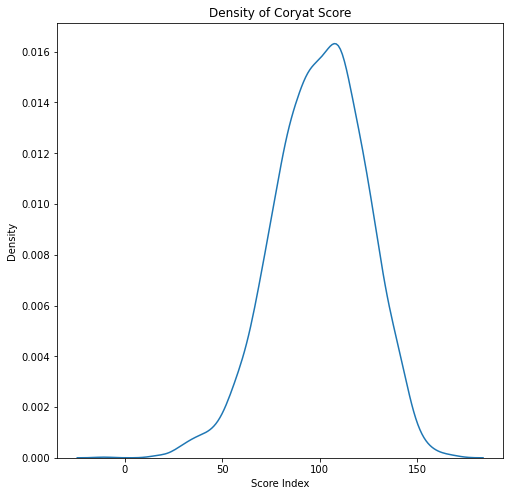

In [10]:
fig, ax = plt.subplots(figsize = (8,8))
sns.kdeplot(data = grouped_sum_coryat, x = 'rating_index')
plt.title('Density of Coryat Score')
plt.xlabel('Score Index')
plt.show()